In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import mygene

from rpy2.robjects import pandas2ri

pandas2ri.activate()

%load_ext rpy2.ipython

sc.settings.set_figure_params( dpi=80 )

# Format input files

In [25]:
# Load healthy individual 3-006 and Severe Dengue serotype 3 indivudal 1-026. These two patients have the most cells available.

def read_csv_sc( file_loc, md_loc, name=None ):
    dataset = pd.read_csv( file_loc )
    dataset_md = pd.read_csv( md_loc )
    dataset = dataset.rename( columns={ "Unnamed: 0" : "Accession" } )
    dataset = dataset.set_index( "Accession" )
    new_col_names = list()
    for i in dataset.columns:
        new_col_names.append( "_".join( i.split( "_" )[:3] ) )
    dataset.columns = new_col_names
    dataset = sc.AnnData( dataset.T )
    dataset.obs_names_make_unique()
    dataset.X = sp.sparse.csr_matrix( dataset.X )
    
    if name is None:
        dataset.obs["Sample"] = dataset_md["PatientID"].values
    else:
        dataset.obs["Sample"] = name
    dataset.obs["Tissue"] = dataset_md["Tissue"].values
    dataset.obs["Type"] = dataset_md["Type"].values
    dataset.obs["Sex"] = dataset_md["Sex"].values
    dataset.obs["Age"] = dataset_md["Age"].values
    dataset.obs["Disease_Status"] = dataset_md["Disease_Status"].values
    dataset.obs["Virus_Reads"] = dataset_md["VirusReads"].values 
    
    return dataset

patient_healthy = read_csv_sc( "/Users/natem/codeSandbox/tcr/0_data/Zanini/3-006.csv", "/Users/natem/codeSandbox/tcr/0_data/Zanini/3-006.metadata.csv", name="Healthy" )
patient_dengue = read_csv_sc( "/Users/natem/codeSandbox/tcr/0_data/Zanini/1-026.csv", "/Users/natem/codeSandbox/tcr/0_data/Zanini/1-026.metadata.csv", name="Dengue" )

mg = mygene.MyGeneInfo()
gene_df = mg.querymany( patient_healthy.var_names, scopes='ensembl.gene', fields="symbol", as_dataframe=True, returnall=True ) 
gene_df = gene_df["out"]
newlist = list()
for i in patient_healthy.var_names:
    query = str( gene_df.symbol[i] )
    if query == "nan":
        newlist.append( i )
    else:
        newlist.append( query )
patient_healthy.var_names = newlist
patient_dengue.var_names = newlist

patient_healthy.var_names_make_unique()
patient_dengue.var_names_make_unique()

patient_healthy = patient_healthy[:,~patient_healthy.var_names.str.contains( "__" )]
patient_dengue = patient_dengue[:,~patient_dengue.var_names.str.contains( "__" )]
patient_healthy = patient_healthy[:,:-1]
patient_dengue = patient_dengue[:,:-1]

patient_healthy.write_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/healthy_pbmcs.hdf5")
patient_dengue.write_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/dengue_pbmcs.hdf5")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/venv/lib/python3.7/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


2 input query terms found dup hits:
	[('ENSG00000229425', 2), ('ENSG00000249981', 2)]
4013 input query terms found no hit:
	['ENSG00000069712', 'ENSG00000116883', 'ENSG00000116957', 'ENSG00000122718', 'ENSG00000130201', 'ENS


# Dataset Selection
One benefit of the raise of single cell RNA-seq is the release of plentiful numbers of organism and cell type specific datasets. For this workshop, we'll be using two datasets provided by Zanini et al. from their paper [Virus-inclusive single-cell RNA sequencing reveals the molecular signature of progression to severe dengue](https://doi.org/10.1073/pnas.1813819115).

In brief, blood samples were collected from individuals presenting to a hospital in Columbia who met criteria for Dengue virus infection. Peripheral blood mononuclear cells were extracted and FACS was performed to enrich various immune cell types and to sort single cells in 384 well plates for a modified 5' RACE RNA-seq library preparation.

# Loading the data
The first thing to do is to load the data. In this case, it is provided as a TSV file where each column lists the feature (for our purposes this means gene) counts for a given cell (technically called observations and labeled as the cell barcode found in the sequencing data).

| Accession | Gene | Cell_1 | Cell_2 | Cell_3 |
| --------- | ---- | ------ | ------ | -------|
| ENSG00000252305.1 | SNORA74 | 1 | 2 | 3 |   
| ENSG00000154874.14 | CCDC144B | 1 | 2 | 3 |
| ENSG00000233528.4 | LINC00430 | 0 | 1 | 0 |    

Another common format you'll see is the sparse matrix format (often designated by .mtx files), which provides significant storage saving for data contains a lot of zeroes (like single cell expression data). This format is also tab seperated which each row contains the positive count for a single gene in a single cell. In this way only, only counts for genes which where observed in a cells sequnecing data are recorded, rather than the plethera of counts for genes not observed. 

In [2]:
patient_dengue = sc.read_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/dengue_pbmcs.hdf5" )
patient_healthy = sc.read_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/healthy_pbmcs.hdf5" )

scdata = patient_dengue.concatenate( patient_healthy, join="outer" )

Once loaded, the data is put into an AnnData format. It can be though of as the matrix displayed above, but with the ability for rows and columns to be annotated. 

The data itself can be access in the ".X" field. This field will change according to what preprocessing you perform on it, but the original counts can always be found in the ".raw" field. 

Individual cell annotations are found in the ".obs" field. We can add annotations like, what sample a cell belongs to, or what cell type it is. We can do the former now and add a label that each of the cells in the loaded dataset come from patient 1.

# Preprocessing

In [3]:
print( "scdata contains {} cells with counts for {} genes".format( scdata.n_obs, scdata.n_vars ) )


scdata contains 3637 cells with counts for 60715 genes


So all together our datasets includes 3637 observations. While the majority of these are likely cells, this number is inflated by the presense of artifacts like dead cells, doublets, and barcode crosstalk. We will impose two limits on observations to filter these out.

The first of these is removing observations where greater than 15% of molecules align to genes from the mitocondrial genome. Expression of mitocondrial genes is associated with poor quality cells which have lost cytoplasmic RNA for one reason or another. Limit was selected so as to remove cells which lowly expressing cells with high mitochondrial counts.

... storing 'Disease_Status' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Type' as categorical


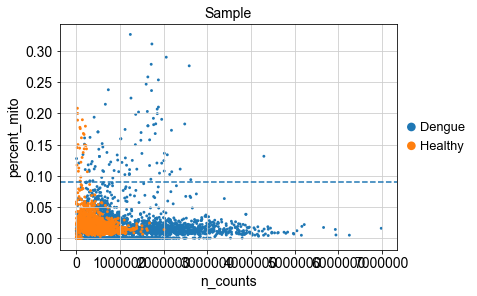

123 observations will be removed with proposed mitochondrial limit


In [4]:
proposed_mt_limit = 0.09

mito_genes = scdata.var_names.str.startswith( "MT-" )
scdata.obs['percent_mito'] = np.sum( scdata[:, mito_genes].X, axis=1 ) / np.sum( scdata.X, axis=1 )
scdata.obs['n_counts'] = scdata.X.sum( axis=1 )
scdata.var['mito'] = mito_genes

ax = plt.subplot()
sc.pl.scatter( scdata, "n_counts", "percent_mito", color="Sample", show=False, ax=ax )
plt.axhline( proposed_mt_limit, 0, 60000, linestyle="dashed" )
plt.show()

print( "{} observations will be removed with proposed mitochondrial limit".format( scdata[scdata.obs["percent_mito"] > proposed_mt_limit].n_obs ) )

In [6]:
scdata = scdata[scdata.obs["percent_mito"] < proposed_mt_limit]
print( "Number of observations after MT filter: {}".format( scdata.n_obs ) )

Number of observations after MT filter: 3514


The second filter will be a cell size filter. We will filter observations which contain either too little or too many genes counts or total counts as these would be indicative of dead cells and multiplets, respectively. 

As the number of unique gene counts per cell is normally distibuted, we should visually observation a gausian distribution in the number of molecules each observation contains. The upper and lower limits of cell size are selected where the distribution lacks normality.

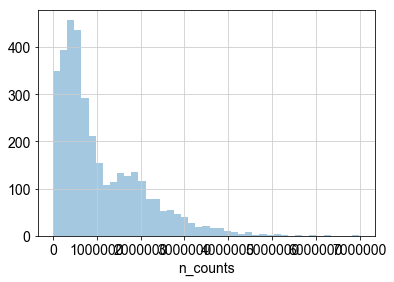

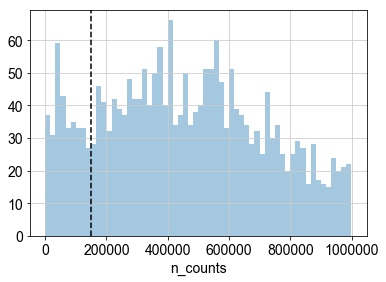

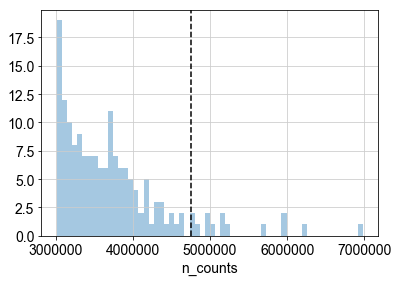

In [10]:
lower_counts = 150000
upper_counts = 4750000

#Thresholding decision: counts
sns.distplot( scdata.obs["n_counts"], kde=False )
plt.show()

sns.distplot( scdata.obs.loc[scdata.obs["n_counts"]<1e6, "n_counts"], kde=False, bins=60 )
plt.axvline( lower_counts, 0, 100, linestyle="dashed", color="black" )
plt.show()

sns.distplot( scdata.obs.loc[scdata.obs["n_counts"]>3e6, "n_counts"], kde=False, bins=60 )
plt.axvline( upper_counts, 0, 20, linestyle="dashed", color="black" )
plt.show()

The histrogram of the number of counts per cells reveal a peak of cells with less than 150,000 counts. Given the distribution of counts, these are likely to be uninformative and likely arise as a a result of debris or dead cells in wells.

Likewise, the histogram shows a number of outlier observations which contain massive numbers of counts (>4,750,000 reads). We will remove these as well.

The same basic analysis is performed on unique gene counts as well. 

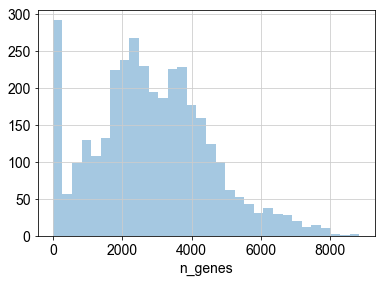

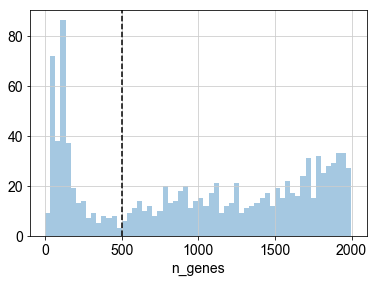

In [9]:
lower_genes = 500

scdata.obs["n_genes"] = [row.count_nonzero() for row in scdata.X]

sns.distplot( scdata.obs["n_genes"], kde=False )
plt.show()

sns.distplot( scdata.obs.loc[scdata.obs["n_genes"] < 2000, "n_genes"], kde=False, bins=60 )
plt.axvline( 500, 0, 100, linestyle="dashed", color="black" )
plt.show()


In the histogram of unique gene counts per shows shows that a there is a large peak of cells expression a less than 500 genes. This peak is probably made up of either dead cells or wells that had only ambient RNA as input. 

In [11]:
print( "Total number of cells: {}".format( scdata.n_obs ) )

sc.pp.filter_cells( scdata, min_genes=lower_genes )
print( "Number of observations after min genes filter: {}".format( scdata.n_obs ) )

sc.pp.filter_cells( scdata, min_counts=lower_counts )
print( "Number of observations after min count filter: {}".format( scdata.n_obs ) )

sc.pp.filter_cells( scdata, max_counts=upper_counts )
print( "Number of observations after max count filter: {}".format( scdata.n_obs ) )

Total number of cells: 3514
Number of observations after min genes filter: 3179
Number of observations after min count filter: 2971
Number of observations after max count filter: 2957


The last filter we apply will be on genes. We only want to included in downstream analyses genes which are expressed in at least 20 cells. We're going to filter out genes which don't occur in 1% of cells.

In [12]:
proposed_gene_limit = 0.01

print( 'Total number of genes: {}'.format( scdata.n_vars ) )

# Filters out 0 count genes. Really 20 count genes.
sc.pp.filter_genes( scdata, min_cells=scdata.n_obs * 0.01 )
print( 'Number of genes after cell filter: {}'.format( scdata.n_vars ) )

Total number of genes: 60715
Number of genes after cell filter: 25055


# Normalization
We're going to use a pooled normalization approach which is implemented in the *scran* R package with the *computeSizeFactors* function to compute size factors for each cell.

To do this we'll quickly log normalize a copy of the data we have and use louvain clustering at a middling resolution to identify broad cell types. We'll then use these clusters when normalizing to account for cell type specific coverage differences.

In [13]:
scdata_copy = scdata.copy()
sc.pp.normalize_per_cell( scdata_copy, counts_per_cell_after=1e6 )
sc.pp.log1p( scdata_copy )
sc.pp.pca( scdata_copy, svd_solver='arpack', n_comps=15 )
sc.neighbors.neighbors( scdata_copy )
sc.tl.louvain( scdata_copy, key_added="groups", resolution=0.5 )

input_groups = scdata_copy.obs['groups']
data_mat = scdata.X.T.toarray()

In [14]:
%%R -i data_mat -i input_groups -o size_factors
library( scran )
#library( RColorBrewer )
#library( slingshot )
#library( gam )
#library( clusterExperiment )
#library( ggplot2 )
#library( plyr )
size_factors = computeSumFactors( data_mat, clusters=input_groups, min.mean=0.1, positive=TRUE )

R[write to console]: Loading required package: BiocParallel

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans

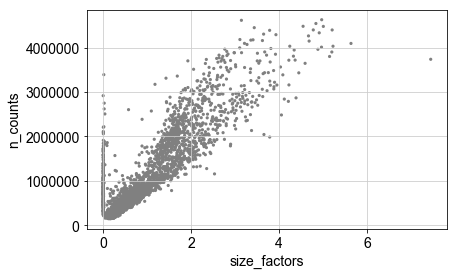

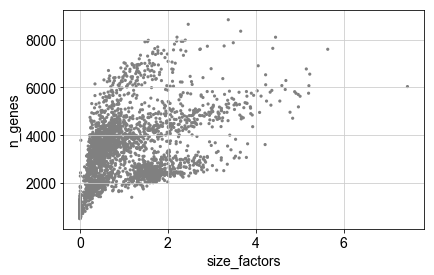

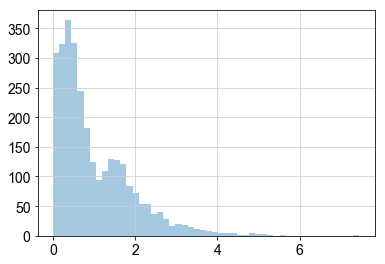

In [15]:
del scdata_copy

# Visualize the estimated size factors
scdata.obs['size_factors'] = size_factors

sc.pl.scatter( scdata, 'size_factors', 'n_counts' )
sc.pl.scatter( scdata, 'size_factors', 'n_genes' )

sns.distplot( size_factors, bins=50, kde=False )
plt.show()

In [16]:
#Keep the count data in a counts layer
scdata.layers["counts"] = scdata.X.copy()

#Normalize adata 
scdata.X /= scdata.obs["size_factors"].values[:,None]
sc.pp.log1p( scdata )

# Store the full data set in 'raw' as log-normalised data for statistical testing
scdata.raw = scdata

# Batch Correction

In [17]:
# ComBat batch correction
#sc.pp.combat( scdata, key="Sample" )

/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:338: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


# Highly Variable Genes

Number of highly variable genes: 25055


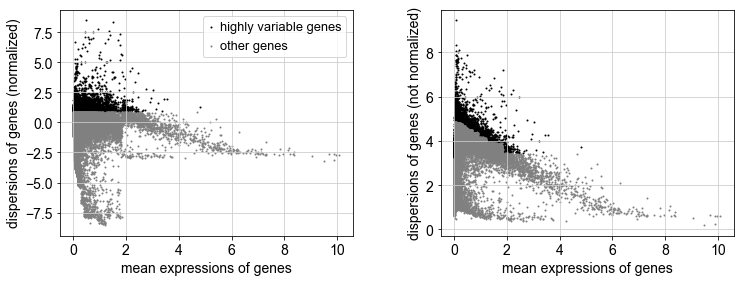

In [18]:
sc.pp.highly_variable_genes( scdata, flavor='cell_ranger', n_top_genes=4000 )
print( "Number of highly variable genes: {}".format( len( scdata.var["highly_variable"] ) ) )

sc.pl.highly_variable_genes( scdata )

# Visualization

In [19]:
# Calculate the visualizations
sc.pp.pca( scdata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors( scdata )

sc.tl.umap( scdata )

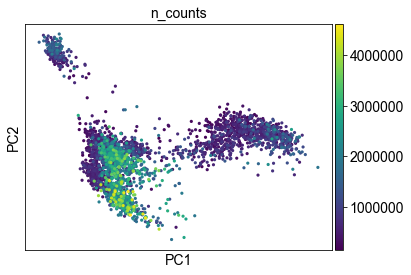

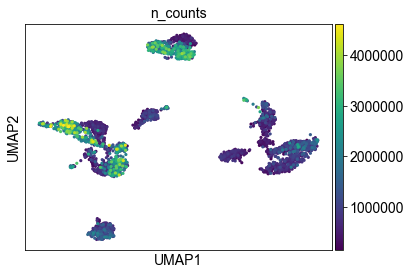

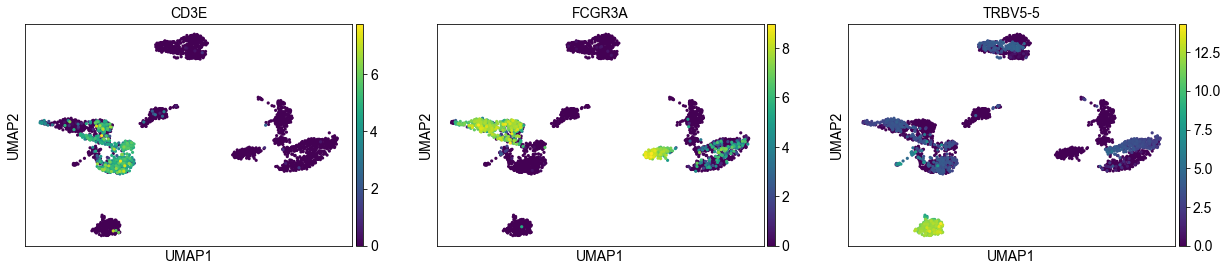

In [125]:
sc.pl.pca( scdata, color="n_counts" )
sc.pl.umap( scdata, color="n_counts" )
sc.pl.umap( scdata, color=["CD3E", "FCGR3A", "TRBV5-5"] )

# T Cell Selection

0    602
1    553
2    528
3    495
4    245
5    197
6    175
7    162
Name: louvain_r0.3, dtype: int64


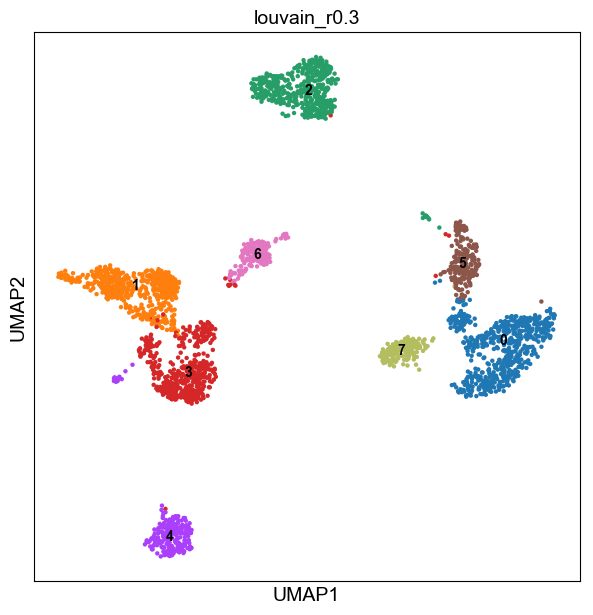

In [22]:
sc.tl.louvain( scdata, resolution=0.3, key_added="louvain_r0.3", random_state=42 )
print( scdata.obs["louvain_r0.3"].value_counts() )

plt.figure( dpi=100, figsize=(7,7) )
ax=plt.subplot()
sc.pl.umap( scdata, color="louvain_r0.3", show=False, ax=ax, legend_loc="on data" )
plt.show()

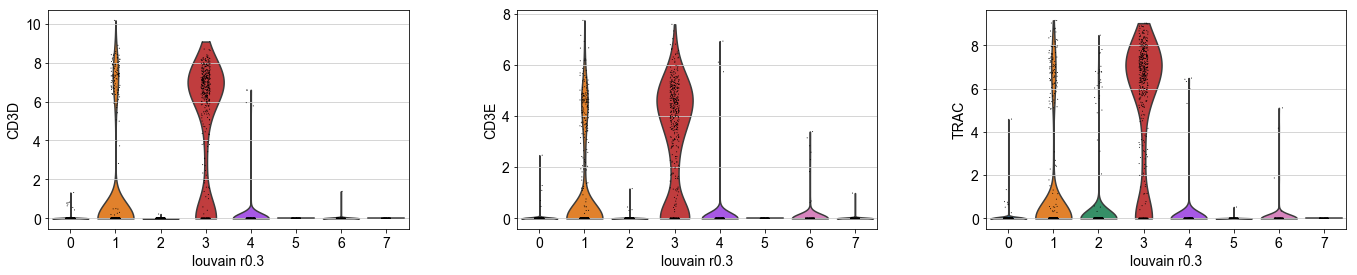

In [23]:
sc.pl.violin( scdata, ["CD3D", "CD3E", "TRAC"], groupby="louvain_r0.3" )

In [27]:
# Merge and rename T cell cluster
scdata.obs["cluster"] = (scdata.obs["louvain_r0.3"]
                         .map(lambda x: {"1": "T Cell", "3" : "T Cell"}.get(x, x) )
                         .astype("category") )

In [43]:
scdata.obs["cluster"].value_counts()

T Cell    1048
0          602
2          528
4          245
5          197
6          175
7          162
Name: cluster, dtype: int64

# Generate Blacklist genes
We'll use a technique developed by Szabo et al. to generate a blacklist of genes that are overexpressed in non-T cell cluster and use those to remove contaminating cells in the T cell cluster.

Briefly, we conduct differential expression analysis pairwise between the T cell cluster and each non-T cell cluster. We then add all genes which are highly specific for non-T cells to the blacklist by identifying all genes which have an adjusted p-value of greater than 0.001 and greater than 10-fold enrichment in non-T cell clusters. We then remove from this blacklist any gene which shows positive enrichment in any T cell cluster.

In [46]:
sc.tl.rank_genes_groups( scdata, groupby="cluster", groups=[0,2,4,5,6,7], reference="T Cell", method="wilcoxon", use_raw=False, n_genes=-1 )

/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:362: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:362: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:362: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:362: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:362: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldc

In [95]:
blacklist = list()
for i in [ "0", "2", "4", "5", "6", "7"]:
    blacklist_genes = (scdata.uns["rank_genes_groups"]["logfoldchanges"][i] > 10 ) & ( scdata.uns["rank_genes_groups"]["pvals_adj"][i] < 0.001 )
    blacklist.extend( scdata.uns["rank_genes_groups"]["names"][i][blacklist_genes] )
blacklist = np.unique( blacklist )

In [97]:
sc.tl.rank_genes_groups( scdata, groupby="cluster", groups=["T Cell"], reference="rest", method="wilcoxon", use_raw=False, n_genes=-1 )

/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


In [102]:
whitelist_genes = (scdata.uns["rank_genes_groups"]["logfoldchanges"]["T Cell"] > 10 ) & ( scdata.uns["rank_genes_groups"]["pvals_adj"]["T Cell"] < 0.001 )
print( scdata.uns["rank_genes_groups"]["names"]["T Cell"][whitelist_genes] )

['PRF1' 'FGFBP2' 'TRDC' 'TRBJ1-5' 'TRBJ1-3']


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [106]:
sum( scdata.uns["rank_genes_groups"]["logfoldchanges"]["T Cell"] < -10 )

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


6

In [124]:
scdata.var[ scdata.var.index.str.startswith( "TRBV" )]

,mito,n_cells,highly_variable,means,dispersions,dispersions_norm
TRBV21OR9-2,False,48,False,0.052797,3.548525,-0.421969
TRBV20OR9-2,False,51,True,0.042610,4.942035,1.115755
TRBV4-1,False,30,True,0.054484,6.423624,2.496176
TRBV7-3,False,123,True,0.166234,5.883994,2.339882
TRBV5-3,False,483,True,0.562633,4.643382,1.217091
TRBV9,False,911,True,1.058134,4.997377,3.013426
TRBV10-1,False,321,True,0.404817,5.479769,2.449862
TRBV6-5,False,33,True,0.050532,5.527062,1.586190
TRBV5-5,False,1083,True,1.889182,4.240833,1.886729
TRBV7-6,False,155,True,0.177223,5.736924,2.350768
